In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy
import scipy.signal

In [2]:
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['font.family'] = 'Arial'

In [3]:
# Use a dictionary of labels to keep names neater
sheet_labels = { 'ext1': "Ext1_067",
               'ext2': "Ext2_068",
               'RT': 'Rock_Temp',
               'fac': 'Facade',
               'roof': 'Roof' }

# Import Data from TT95 - March 2022 Field Trip
ext1 = pd.read_excel("../Raw Data/Raw_data_consolidated Cleaned.xlsx", sheet_name=sheet_labels['ext1'])
ext2 = pd.read_excel("../Raw Data/Raw_data_consolidated Cleaned.xlsx", sheet_name=sheet_labels['ext2'])
rt = pd.read_excel("../Raw Data/Raw_data_consolidated Cleaned.xlsx", sheet_name=sheet_labels['RT'])
facade = pd.read_excel("../Raw Data/Raw_data_consolidated Cleaned.xlsx", sheet_name=sheet_labels['fac'])
roof = pd.read_excel("../Raw Data/Raw_data_consolidated Cleaned.xlsx", sheet_name=sheet_labels['roof'])

In [4]:
# Calculate displacement and cummulative displacement
ext1['Cr_disp'] = ext1['Cr_Ap'].diff()
ext1['Cr_sum_disp'] = ext1['Cr_disp'].cumsum()

START_DATE = '04-15-2019'

# Disregard the scarce random data observed in 2021 and 2022 and clean NaNs
ext1 = ext1[(ext1['Datetime'] <= pd.to_datetime('2019-12-31'))&(ext1['Datetime'] >= pd.to_datetime(START_DATE))]
ext1.dropna(inplace=True)

ext2['Cr_disp'] = ext2['Cr_Ap'].diff()
ext2['Cr_sum_disp'] = ext2['Cr_disp'].cumsum()

ext2 = ext2[(ext2['Datetime'] <= pd.to_datetime('2019-12-31'))&(ext1['Datetime'] >= pd.to_datetime(START_DATE))]
ext2.dropna(inplace=True)
total_ext = pd.DataFrame(ext1['Datetime'])
total_ext['Disp_ext1'] = ext1['Cr_disp']
total_ext['Disp_ext2'] = ext2['Cr_disp']
total_ext['Cr_disp'] = np.sqrt(np.power(ext1.Cr_disp, 2) + np.power(ext2.Cr_disp, 2))
total_ext['Cr_sum_disp'] = total_ext['Cr_disp'].cumsum()
total_ext['Air_Temp'] = ext1['Air_Temp']
total_ext
#total_ext['Datetime'].iloc[0]
END_DATE = total_ext['Datetime'].iloc[-1]

In [5]:
font_title = {'family': 'Arial',
             'size': 18
             }

font_labels = {'family': 'Arial',
               'size': 16 
              }

font_ticks = {'family': 'Arial',
               'size': 14 
              }

font_ticks_dates = {'family': 'Arial',
               'size': 14,
                    'rotation':45
                   }

In [6]:
# Helper function to select observations between dates and not repeating code
def filter_dates(df, date_column, date_from, date_to):
    temp = (df[date_column] >= date_from) & (df[date_column] < date_to)
    return df[temp]

In [7]:
# Select observations for the same dates that we have availabel extensometer data
roof_filt = filter_dates(roof, 'Datetime_corrected', START_DATE, END_DATE)
facade_filt = filter_dates(facade, 'Datetime_corrected', START_DATE, END_DATE)
rt_filt = filter_dates(rt, 'Datetime', START_DATE, END_DATE)

In [8]:
# Resample all datasets to 1 hour intervals to have corresponding datetimes on the readings, using mean hourly values
ext1_1h = ext1.resample('H', on='Datetime').mean()
ext2_1h = ext2.resample('H', on='Datetime').mean()
total_ext_1h = total_ext.resample('H', on='Datetime').mean()
roof_1h = roof_filt.resample('H', on='Datetime_corrected').mean()
facade_1h = facade_filt.resample('H', on='Datetime_corrected').mean()
rt_1h = rt_filt.resample('H', on='Datetime').mean()

# Resample all datasets to 1 day intervals to have corresponding datetimes on the readings, using the mean daily values for temp and sum for displacements
ext1_1d = pd.DataFrame()
ext1_1d['Cr_disp'] = ext1.resample('D', on='Datetime').sum()['Cr_disp']
ext1_1d['Air_Temp'] = ext1.resample('D', on='Datetime').mean()['Air_Temp']
ext1_1d['Cr_sum_disp'] = ext1_1d['Cr_disp'].cumsum()

ext2_1d = pd.DataFrame()
ext2_1d['Cr_disp'] = ext2.resample('D', on='Datetime').sum()['Cr_disp']
ext2_1d['Air_Temp'] = ext2.resample('D', on='Datetime').mean()['Air_Temp']
ext2_1d['Cr_sum_disp'] = ext2_1d['Cr_disp'].cumsum()

roof_1d = roof_filt.resample('D', on='Datetime_corrected').mean()
facade_1d = facade_filt.resample('D', on='Datetime_corrected').mean()
rt_1d = rt_filt.resample('D', on='Datetime').mean()
ext2_1d

,Cr_disp,Air_Temp,Cr_sum_disp
Datetime,,,
2019-04-14,0.0,25.600000,0.0
2019-04-15,-1.0,25.837500,-1.0
2019-04-16,1.0,25.875000,0.0
2019-04-17,-1.0,25.744000,-1.0
2019-04-18,1.0,25.741667,0.0
...,...,...,...
2019-08-12,0.0,31.666667,-198.0
2019-08-13,0.0,31.670833,-198.0
2019-08-14,0.0,31.654167,-198.0


<h1>Displacement of the Extensometers</h1>

<ul>
<li>Extensometer 1: Installed between Pillars K and J, crossing the tensile fracture
<li>Extensometer 2: Installed between Pillar K and West Wall NOT crossing the Tensile fracture
</ul>

<h2>Observations</h2>
<ul>
    <li>Both extensometers contract over time (negative displacements)
    <li>Distinct "jumps" in displacement are observed in both extensometer readings, which coincide for both instruments
    <li>Rate of displacement is large in the first few weeks (May 1st 2019 - June 7 2019) and then slows down
</ul>

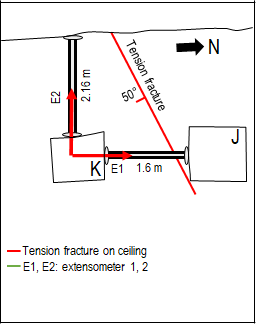
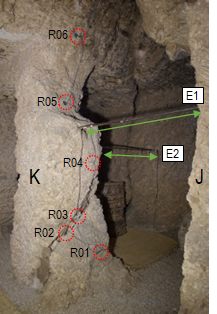

C:\Users\vasil\AppData\Local\Temp\ipykernel_784\390366155.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), fontdict=font_ticks_dates)
C:\Users\vasil\AppData\Local\Temp\ipykernel_784\390366155.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontdict=font_ticks)


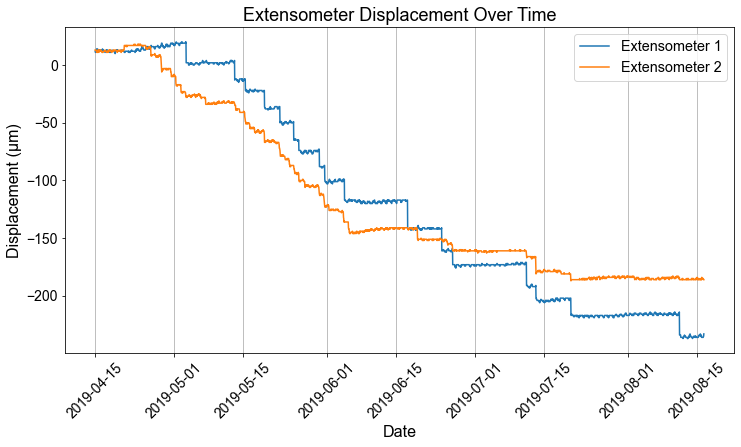

In [9]:
fig = plt.figure(figsize=(12,6))
ax = plt.axes()

ax.plot(ext1.Datetime, ext1.Cr_sum_disp, label='Extensometer 1')
ax.plot(ext2.Datetime, ext2.Cr_sum_disp, label='Extensometer 2')
plt.draw()

ax.set_xlabel('Date', fontdict=font_labels)
ax.set_ylabel('Displacement (μm)', fontdict=font_labels)

ax.set_xticklabels(ax.get_xticklabels(), fontdict=font_ticks_dates)
ax.set_yticklabels(ax.get_yticklabels(), fontdict=font_ticks)

ax.grid(axis='x')

ax.legend(fontsize='x-large')

ax.set_title('Extensometer Displacement Over Time', fontdict=font_title)
plt.show()

<h1>Ambient Temperature</h1>

Temperature measurements over time can be seen in the figure below. The temperature measurements are sourced from 3 different locations:

<ol>
    <li>The interior temperature measured by the extensometer's integrated temperature sensor - results might be affected due to heat conduction from the rock</li>
    <li>Temperature sensor installed at the roof of the tomb, measuring exterior temperature</li>
    <li>Temperature sensor installed at the facade of the tomb measuring exterior temperature</li>
</ol>

<h2>Observations</h2>
<ul>
    <li>The temperature measurements span from the mid-spring, to the end of the summer (heating period) </li>
    <li>Exterior temperatures are rising fast until the first week of june and then remain relatively constant (except for daily fluctuations)</li>
    <li>Interior temperatures are much more stable with minor fluctuations, but they seem follow the same long term pattern with the exterior temperatures</li>
</ul>

C:\Users\vasil\AppData\Local\Temp\ipykernel_784\1314671423.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), fontdict=font_ticks_dates)
C:\Users\vasil\AppData\Local\Temp\ipykernel_784\1314671423.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontdict=font_ticks)


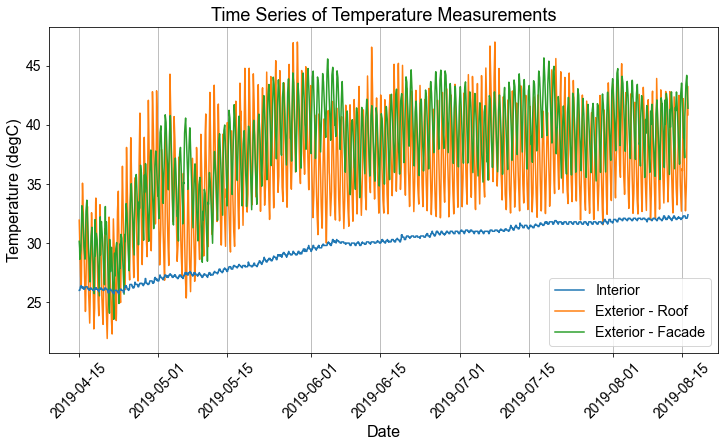

In [10]:
fig = plt.figure(figsize=(12,6))
ax = plt.axes()

ax.plot(total_ext_1h.Air_Temp, label='Interior',zorder=3)
ax.plot(roof_1h.Air_Temp, label='Exterior - Roof')
ax.plot(facade_1h.Air_Temp, label='Exterior - Facade')
plt.draw()

ax.set_xlabel('Date', fontdict=font_labels)
ax.set_ylabel('Temperature (degC)', fontdict=font_labels)

ax.set_xticklabels(ax.get_xticklabels(), fontdict=font_ticks_dates)
ax.set_yticklabels(ax.get_yticklabels(), fontdict=font_ticks)

ax.grid(axis='x')

ax.set_title('Time Series of Temperature Measurements', fontdict=font_title)

ax.legend(fontsize='x-large')
plt.show()

<h2>Effect of Long Term Heating</h2>

In the following figure we plotted the heating degree days over time for exterior and interior temperature measurements - an indication of the cumulative effect of constant heating the rock - and superimposed the extensometer displacements. We see that displaments follow the heating of the rock closely. Thus we might see an indication that rising temperatures over the summer periods is one of the drivers behind the increasing displacement. If the reverse pattern is followed in the winter months, during cooling of the rock, then that might be an indication of cyclic thermal loading at the tip of the crack, hinting thermal fatigue and driving further crack propagation (similar to what we saw on Rodrigo's work at KV42? cite it on the poster).

C:\Users\vasil\AppData\Local\Temp\ipykernel_784\637397536.py:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), fontdict=font_ticks_dates)
C:\Users\vasil\AppData\Local\Temp\ipykernel_784\637397536.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontdict=font_ticks)
C:\Users\vasil\AppData\Local\Temp\ipykernel_784\637397536.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels(ax2.get_yticklabels(), fontdict=font_ticks)


Text(0.5, 1.0, 'Time Series of Temperature Measurements')

<Figure size 720x576 with 0 Axes>

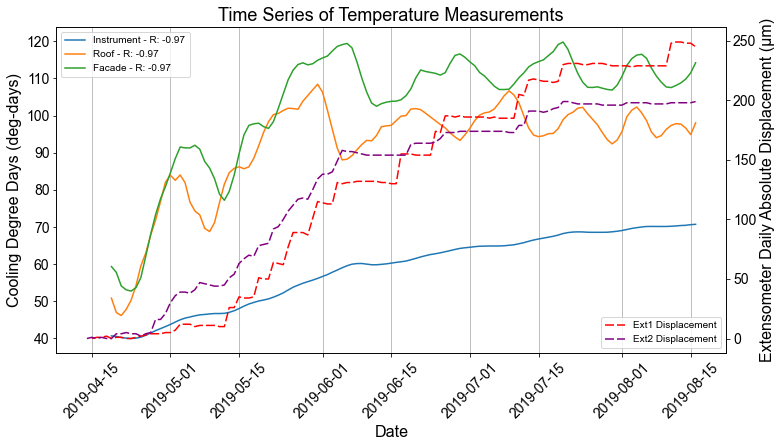

In [11]:
dd_threshold = 18 # the threshold upon heating/cooling degree days are calculated

ext1_1d['CDD_Step'] = ext1_1d.Air_Temp - dd_threshold
ext1_1d['CDD'] = ext1_1d['CDD_Step'].cumsum()

roof_1d['CDD_Step'] = roof_1d.Air_Temp - dd_threshold
roof_1d['CDD'] = roof_1d['CDD_Step'].cumsum()

facade_1d['CDD_Step'] = facade_1d.Air_Temp - dd_threshold
facade_1d['CDD'] = facade_1d['CDD_Step'].cumsum()


plt.figure(figsize=(10,8))

fig = plt.figure(figsize=(12,6))
ax = plt.axes()
ax.plot(ext1_1d.CDD_Step.rolling(5).sum(), label='Instrument - R: ' + str('%.2f' % np.corrcoef(ext1_1d.CDD, ext1_1d.Cr_sum_disp)[1][0]))
ax.plot(roof_1d.CDD_Step.rolling(5).sum(), label='Roof - R: ' + str('%.2f' % np.corrcoef(ext1_1d.CDD, ext1_1d.Cr_sum_disp)[0][1]))
ax.plot(facade_1d.CDD_Step.rolling(5).sum(), label='Facade - R: ' + str('%.2f' % np.corrcoef(ext1_1d.CDD, ext1_1d.Cr_sum_disp)[0][1]))

ax2 = ax.twinx()
ax2.plot(np.abs(ext1_1d.Cr_sum_disp), color='red', dashes=[6,2], label='Ext1 Displacement')
ax2.plot(np.abs(ext2_1d.Cr_sum_disp), color='purple', dashes=[6,2], label='Ext2 Displacement')

plt.draw()

ax.set_xlabel('Date', fontdict=font_labels)
ax.set_ylabel('Cooling Degree Days (deg-days)', fontdict=font_labels)
ax2.set_ylabel('Extensometer Daily Absolute Displacement (μm)', fontdict=font_labels)

ax.set_xticklabels(ax.get_xticklabels(), fontdict=font_ticks_dates)
ax.set_yticklabels(ax.get_yticklabels(), fontdict=font_ticks)
ax2.set_yticklabels(ax2.get_yticklabels(), fontdict=font_ticks)

ax.grid(axis='x')

ax.legend()
ax2.legend(loc='lower right')


ax.set_title('Time Series of Temperature Measurements', fontdict=font_title)

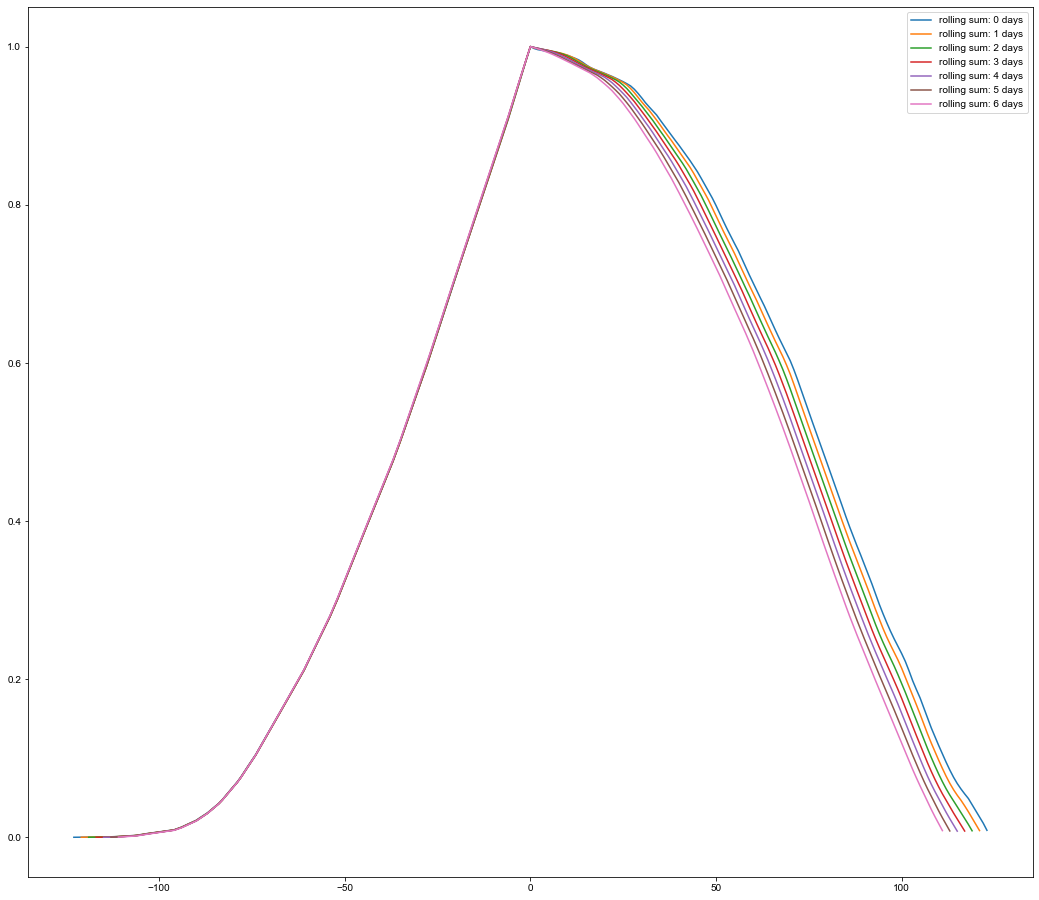

In [12]:
import scipy.signal

rolling_corrs = []
rolling_corrs_lags = []
for rl_window in range(1,15,2):
    temp = facade_1d.CDD_Step.rolling(rl_window).sum().dropna().values

    ext1_1d_disp_adjusted=np.abs(ext1_1d.Cr_sum_disp[rl_window-1:].values)

    corr = scipy.signal.correlate(ext1_1d_disp_adjusted, temp)
    lags = scipy.signal.correlation_lags(len(ext1_1d_disp_adjusted), len(temp))
    corr /= np.max(corr)
    
    rolling_corrs.append(corr)
    rolling_corrs_lags.append(lags)
    
plt.figure(figsize=(18,16))
ax = plt.axes()

for i in range(len(rolling_corrs)):
    ax.plot(rolling_corrs_lags[i], rolling_corrs[i], label='rolling sum: %d days' % i)

ax.legend()
plt.show()

C:\Users\vasil\AppData\Local\Temp\ipykernel_784\1828978445.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), fontdict=font_ticks_dates)
C:\Users\vasil\AppData\Local\Temp\ipykernel_784\1828978445.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontdict=font_ticks)


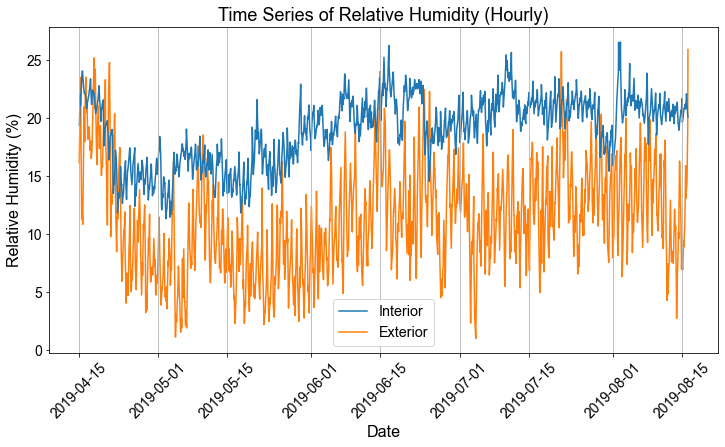

In [13]:
plt.figure(figsize=(12,6))
ax = plt.axes()

ax.plot(roof_1h.RH_internal, label = 'Interior', zorder=1)
ax.plot(facade_1h.RH, label = 'Exterior', zorder=0)

plt.draw()

ax.set_xlabel('Date', fontdict=font_labels)
ax.set_ylabel('Relative Humidity (%)', fontdict=font_labels)

ax.set_xticklabels(ax.get_xticklabels(), fontdict=font_ticks_dates)
ax.set_yticklabels(ax.get_yticklabels(), fontdict=font_ticks)

ax.grid(axis='x')

ax.set_title('Time Series of Relative Humidity (Hourly)', fontdict=font_title)

plt.legend(fontsize='x-large')
plt.show()

C:\Users\vasil\AppData\Local\Temp\ipykernel_784\1886667453.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), fontdict=font_ticks_dates)
C:\Users\vasil\AppData\Local\Temp\ipykernel_784\1886667453.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontdict=font_ticks)


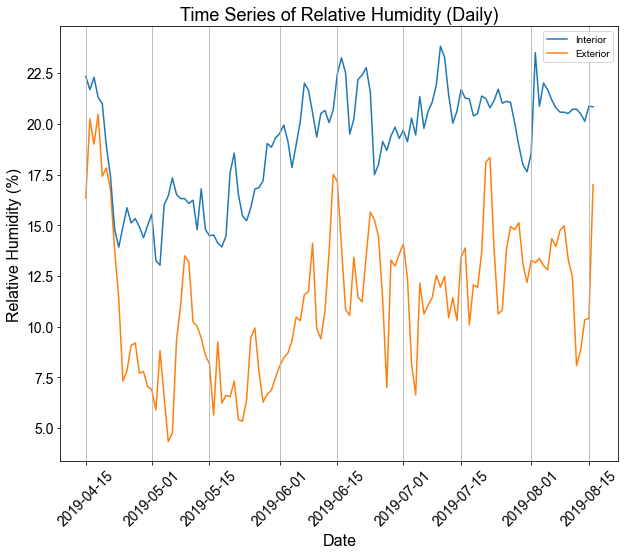

In [14]:
plt.figure(figsize=(10,8))
ax = plt.axes()

ax.plot(roof_1d.RH_internal, label = 'Interior', zorder=1)
ax.plot(facade_1d.RH, label = 'Exterior', zorder=0)

plt.draw()

ax.set_xlabel('Date', fontdict=font_labels)
ax.set_ylabel('Relative Humidity (%)', fontdict=font_labels)

ax.set_xticklabels(ax.get_xticklabels(), fontdict=font_ticks_dates)
ax.set_yticklabels(ax.get_yticklabels(), fontdict=font_ticks)

ax.grid(axis='x')

ax.set_title('Time Series of Relative Humidity (Daily)', fontdict=font_title)

plt.legend()
plt.show()

C:\Users\vasil\AppData\Local\Temp\ipykernel_784\1256981329.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), fontdict=font_ticks_dates)
C:\Users\vasil\AppData\Local\Temp\ipykernel_784\1256981329.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontdict=font_ticks)


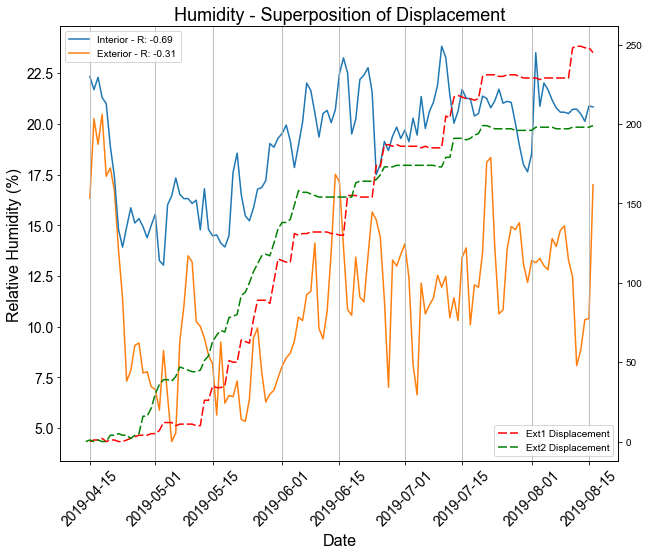

In [15]:
plt.figure(figsize=(10,8))
ax = plt.axes()

ax.plot(roof_1d.RH_internal, label = 'Interior - R: ' + str('%.2f' % np.corrcoef(roof_1d.RH_internal, ext1_1d.Cr_sum_disp)[1][0]), zorder=1)
ax.plot(facade_1d.RH, label = 'Exterior - R: ' + str('%.2f' % np.corrcoef(facade_1d.RH, ext1_1d.Cr_sum_disp)[1][0]), zorder=0)

ax2 = ax.twinx()
ax2.plot(np.abs(ext1_1d.Cr_sum_disp), color='red', dashes=[6,2], label='Ext1 Displacement')
ax2.plot(np.abs(ext2_1d.Cr_sum_disp), color='green', dashes=[6,2], label='Ext2 Displacement')

plt.draw()

ax.set_xlabel('Date', fontdict=font_labels)
ax.set_ylabel('Relative Humidity (%)', fontdict=font_labels)

ax.set_xticklabels(ax.get_xticklabels(), fontdict=font_ticks_dates)
ax.set_yticklabels(ax.get_yticklabels(), fontdict=font_ticks)

ax.grid(axis='x')

ax.set_title('Humidity - Superposition of Displacement', fontdict=font_title)

ax.legend(loc='upper left')
ax2.legend(loc='lower right')
plt.show()

C:\Users\vasil\AppData\Local\Temp\ipykernel_784\4120863299.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), fontdict=font_ticks_dates)
C:\Users\vasil\AppData\Local\Temp\ipykernel_784\4120863299.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontdict=font_ticks)


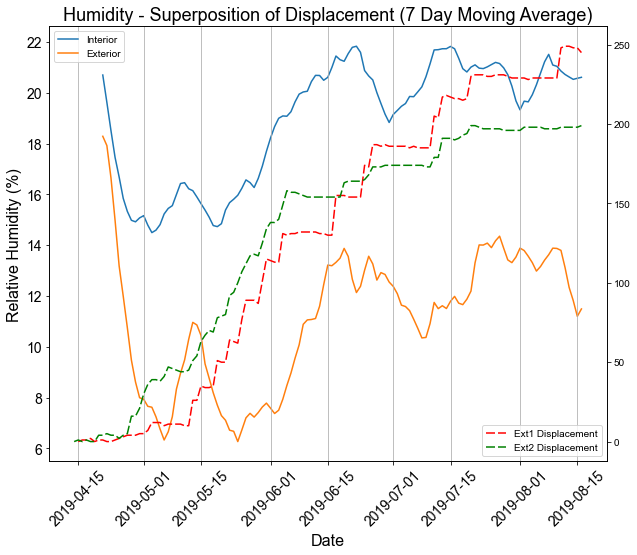

In [16]:
plt.figure(figsize=(10,8))
ax = plt.axes()

ax.plot(roof_1d.RH_internal.rolling(7).mean(), label = 'Interior', zorder=1)
ax.plot(facade_1d.RH.rolling(7).mean(), label = 'Exterior', zorder=0)

ax2 = ax.twinx()
ax2.plot(np.abs(ext1_1d.Cr_sum_disp), color='red', dashes=[6,2], label='Ext1 Displacement')
ax2.plot(np.abs(ext2_1d.Cr_sum_disp), color='green', dashes=[6,2], label='Ext2 Displacement')

plt.draw()

ax.set_xlabel('Date', fontdict=font_labels)
ax.set_ylabel('Relative Humidity (%)', fontdict=font_labels)

ax.set_xticklabels(ax.get_xticklabels(), fontdict=font_ticks_dates)
ax.set_yticklabels(ax.get_yticklabels(), fontdict=font_ticks)

ax.grid(axis='x')

ax.set_title('Humidity - Superposition of Displacement (7 Day Moving Average)', fontdict=font_title)

ax.legend(loc='upper left')
ax2.legend(loc='lower right')
plt.show()

,AT1,AT2,AT3,AT4,AT5,AT6,AT7,AT8,AT9,AT10,AT11,RT_Delta
Datetime,,,,,,,,,,,,
2019-04-15,25.500000,25.679167,25.604167,25.525000,25.783333,25.770833,26.000000,25.708333,26.058333,25.745833,25.904167,0.245833
2019-04-16,25.587500,25.737500,25.687500,25.600000,25.858333,25.820833,25.983333,25.687500,25.962500,25.770833,25.904167,0.183333
2019-04-17,25.560000,25.652000,25.716000,25.600000,25.780000,25.716000,25.760000,25.500000,25.732000,25.568000,25.700000,0.008000
2019-04-18,25.554167,25.616667,25.670833,25.600000,25.758333,25.687500,25.729167,25.500000,25.695833,25.545833,25.683333,-0.008333
2019-04-19,25.533333,25.625000,25.604167,25.587500,25.745833,25.679167,25.783333,25.500000,25.754167,25.554167,25.725000,0.020833
...,...,...,...,...,...,...,...,...,...,...,...,...
2019-08-12,30.495833,31.508333,31.504167,31.500000,31.762500,31.908333,32.412417,32.587375,32.687375,32.783333,32.729167,2.287500
2019-08-13,30.491667,31.512500,31.500000,31.500000,31.770833,31.920833,32.424833,32.595750,32.679083,32.787500,32.745833,2.295833
2019-08-14,30.500000,31.500000,31.508333,31.500000,31.783333,31.912500,32.362375,32.554125,32.641542,32.750000,32.712500,2.250000


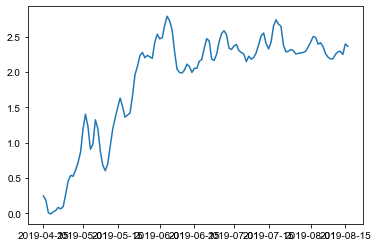

In [17]:
rt_1d['RT_Delta'] = rt_1d['AT10'] - rt_1d['AT1']
plt.plot(rt_1d.RT_Delta)
rt_1d

<h1>ANN fitting</h1>

ANN's will be used here to find the appropriate inputs to a predictive model, predicting the extensometer displacements. 

<p>Candidate inputs:</p>
<ol>
    <li>Temperature at time t and t-lags</li>
    <li>Rock Temperature at time t</li>
    <li>Rolling sum of heating degree days at time t and t-lags</li>
    <li>Rock temperature differential at time t and t-lags</li>
</ol>

<h2>Creating the dataset</h2>

In [18]:
dataset_hourly = pd.merge(ext1_1h['Cr_sum_disp'], ext2_1h['Cr_sum_disp'], on='Datetime', suffixes=('_ext1', '_ext2'))
#dataset_hourly = dataset_hourly.merge(roof_1h['CDD_Step'], right_on='Datetime_corrected', left_index=True)
#dataset_hourly = dataset_hourly.merge(facade_1h['CDD_Step'], left_index=True, right_on='Datetime_corrected', suffixes=('_roof', '_facade'))
dataset_hourly = dataset_hourly.merge(roof_1h['Air_Temp'], left_index=True, right_on='Datetime_corrected')
dataset_hourly = dataset_hourly.merge(roof_1h['Air_Temp'], left_index=True, right_on='Datetime_corrected', suffixes=('_roof', '_facade'))
#dataset_hourly = dataset_hourly.merge(rt_1h['RT_Delta'], left_index=True, right_on='Datetime')
dataset_hourly = dataset_hourly.merge(ext1_1h['Cr_disp'], left_index=True, right_on='Datetime')
dataset_hourly = dataset_hourly.merge(ext2_1h['Cr_disp'], left_index=True, right_on='Datetime', suffixes=('_ext1', '_ext2'))

dataset_hourly

,Cr_sum_disp_ext1,Cr_sum_disp_ext2,Air_Temp_roof,Air_Temp_facade,Cr_disp_ext1,Cr_disp_ext2
Datetime,,,,,,
2019-04-15 00:00:00,12.0,13.0,31.940,31.940,0.0,0.0
2019-04-15 01:00:00,11.0,13.0,31.065,31.065,-1.0,0.0
2019-04-15 02:00:00,12.0,13.0,30.400,30.400,1.0,0.0
2019-04-15 03:00:00,12.0,13.0,29.730,29.730,0.0,0.0
2019-04-15 04:00:00,12.0,13.0,29.060,29.060,0.0,0.0
...,...,...,...,...,...,...
2019-08-16 02:00:00,-236.0,-185.0,40.895,40.895,0.0,0.0
2019-08-16 03:00:00,-236.0,-185.0,42.635,42.635,0.0,0.0
2019-08-16 04:00:00,-235.0,-186.0,43.280,43.280,1.0,-1.0


In [19]:
from sklearn.model_selection import train_test_split

dataset_hourly.to_csv('./Modelling/Datasets/Temp_CDD_to_Disp_hour.csv')

In [20]:
dataset = pd.merge(ext1_1d['Cr_sum_disp'], ext2_1d['Cr_sum_disp'], on='Datetime', suffixes=('_ext1', '_ext2'))
dataset = dataset.merge(roof_1d['CDD_Step'], right_on='Datetime_corrected', left_index=True)
dataset = dataset.merge(facade_1d['CDD_Step'], left_index=True, right_on='Datetime_corrected', suffixes=('_roof', '_facade'))
dataset = dataset.merge(roof_1d['Air_Temp'], left_index=True, right_on='Datetime_corrected')
dataset = dataset.merge(roof_1d['Air_Temp'], left_index=True, right_on='Datetime_corrected', suffixes=('_roof', '_facade'))
dataset = dataset.merge(rt_1d['RT_Delta'], left_index=True, right_on='Datetime')
dataset = dataset.merge(ext1_1d['Cr_disp'], left_index=True, right_on='Datetime')
dataset = dataset.merge(ext2_1d['Cr_disp'], left_index=True, right_on='Datetime', suffixes=('_ext1', '_ext2'))

dataset.to_csv('./Modelling/Datasets/Temp_CDD_to_Disp.csv')

In [24]:
ext1_1h['last_at_max'] = ext1_1h['Air_Temp'].cummax()
ext1_1h

,Air_Temp,Cr_Ap,Cr_disp,Cr_sum_disp,last_at_max
Datetime,,,,,
2019-04-15 00:00:00,26.0,5100.0,0.0,12.0,26.0
2019-04-15 01:00:00,26.0,5099.0,-1.0,11.0,26.0
2019-04-15 02:00:00,26.0,5100.0,1.0,12.0,26.0
2019-04-15 03:00:00,26.0,5100.0,0.0,12.0,26.0
2019-04-15 04:00:00,26.1,5100.0,0.0,12.0,26.1
...,...,...,...,...,...
2019-08-16 02:00:00,32.1,4852.0,0.0,-236.0,32.3
2019-08-16 03:00:00,32.2,4852.0,0.0,-236.0,32.3
2019-08-16 04:00:00,32.2,4853.0,1.0,-235.0,32.3
